<a href="https://colab.research.google.com/github/ericodle/Genre-Classification-Using-LSTM/blob/main/CNN_from_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import os
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim

In [71]:
# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [72]:
# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "/content/drive/MyDrive/data_10.json"

In [73]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [74]:
    # load data
    X, y = load_data(DATA_PATH)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Data succesfully loaded!


In [75]:
from torch.utils.data import TensorDataset, DataLoader

tensor_X_train = torch.Tensor(X_train)
tensor_X_test = torch.Tensor(X_test)
tensor_y_train = torch.Tensor(y_train)
tensor_y_test = torch.Tensor(y_test)

train_dataset = TensorDataset(tensor_X_train,tensor_y_train)
test_dataset = TensorDataset(tensor_X_test,tensor_y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [76]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
                    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

In [77]:
class MLP(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
### Convolutional layer with PrintLayer fxn for debuggin'
  
      #PrintLayer(),

      nn.Conv2d(1,32,kernel_size=(3,3), padding=1),
      #PrintLayer(),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),
      #PrintLayer(),
      nn.BatchNorm2d(32),

      nn.Conv2d(32,32,kernel_size=(3,3), padding=1),
      nn.ReLU(),
      #PrintLayer(),
      nn.MaxPool2d(2, stride=2),
      #PrintLayer(),
      nn.BatchNorm2d(32),

      nn.Conv2d(32,32,kernel_size=(3,3), padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),
      #PrintLayer(),
      nn.BatchNorm2d(32),
 

### Fully-connected layer
      nn.Flatten(),
      nn.ReLU(),
      #PrintLayer(),

      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Dropout(p=0.3),
      #PrintLayer(),

      nn.Linear(256, 64),
      nn.ReLU(),
      nn.Dropout(p=0.3),
      #PrintLayer(),

      nn.Linear(64, 10),
      nn.Softmax(),
      #PrintLayer()
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

In [78]:
model = MLP()

In [79]:
model = model.cuda()

In [80]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [81]:
def accuracy(out, labels):

    _,pred = torch.max(out, dim=1)

    return torch.sum(pred==labels).item()

In [82]:
n_epochs = 100

print_every = 1

valid_loss_min = np.Inf

val_loss = []

val_acc = []

train_loss = []

train_acc = []

total_step = len(train_dataloader)

for epoch in range(1, n_epochs+1):

    running_loss = 0.0

    correct = 0

    total=0

    print(f'Epoch {epoch}\n')

### TRAIN PASS ### ### TRAIN PASS ### ### TRAIN PASS ###

    for (data_, target_) in train_dataloader:

        data_ = data_.to(device)

        data_ = data_.unsqueeze(1)

        data_ = data_.type(torch.cuda.FloatTensor)

        #data_ = data_.reshape(32, 1, 13, 130)

        target_ = target_.to(device)

        target_ = target_.type(torch.cuda.LongTensor) 
        
        #forward
        outputs = model(data_)
        loss = criterion(outputs, target_)
        
        #backward and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        running_loss += loss.item()

        _,pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred==target_).item()

        total += target_.size(0)


    train_acc.append(100 * correct / total)

    train_loss.append(running_loss/total_step)

    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')

    batch_loss = 0

    total_t=0

    correct_t=0

    with torch.no_grad():

        model.eval()

### VAL PASS ### ### VAL PASS ### ### VAL PASS ### ### VAL PASS ###

        for (data_t, target_t) in test_dataloader:
            data_t = data_t.unsqueeze(1)

            #data_t = data_t.reshape(32, 1, 13, 130)

            data_t = data_t.to(device)

            target_t = target_t.type(torch.LongTensor) 

            target_t = target_t.to(device)

            outputs_t = model(data_t)

            loss_t = criterion(outputs_t, target_t)

            batch_loss += loss_t.item()

            _,pred_t = torch.max(outputs_t, dim=1)

            correct_t += torch.sum(pred_t==target_t).item()

            total_t += target_t.size(0)

        val_acc.append(100 * correct_t/total_t)

        val_loss.append(batch_loss/len(test_dataloader))

        network_learned = batch_loss < valid_loss_min

        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')


        

        if network_learned:

            valid_loss_min = batch_loss

            torch.save(model.state_dict(), 'mlp.pt')

            print('Improvement-Detected, save-model')

    model.train()

Epoch 1



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



train-loss: 2.2021, train-acc: 25.8825
validation loss: 2.1057, validation acc: 32.2107

Improvement-Detected, save-model
Epoch 2


train-loss: 2.1487, train-acc: 35.3866
validation loss: 2.0684, validation acc: 42.7142

Improvement-Detected, save-model
Epoch 3


train-loss: 2.1047, train-acc: 45.2908
validation loss: 2.0288, validation acc: 51.2504

Improvement-Detected, save-model
Epoch 4


train-loss: 2.0706, train-acc: 49.7499
validation loss: 2.0016, validation acc: 53.4512

Improvement-Detected, save-model
Epoch 5


train-loss: 2.0438, train-acc: 52.8798
validation loss: 1.9818, validation acc: 55.5185

Improvement-Detected, save-model
Epoch 6


train-loss: 2.0221, train-acc: 55.4238
validation loss: 1.9660, validation acc: 56.9523

Improvement-Detected, save-model
Epoch 7


train-loss: 2.0041, train-acc: 57.0959
validation loss: 1.9503, validation acc: 60.4868

Improvement-Detected, save-model
Epoch 8


train-loss: 1.9882, train-acc: 59.0396
validation loss: 1.9355, validation 

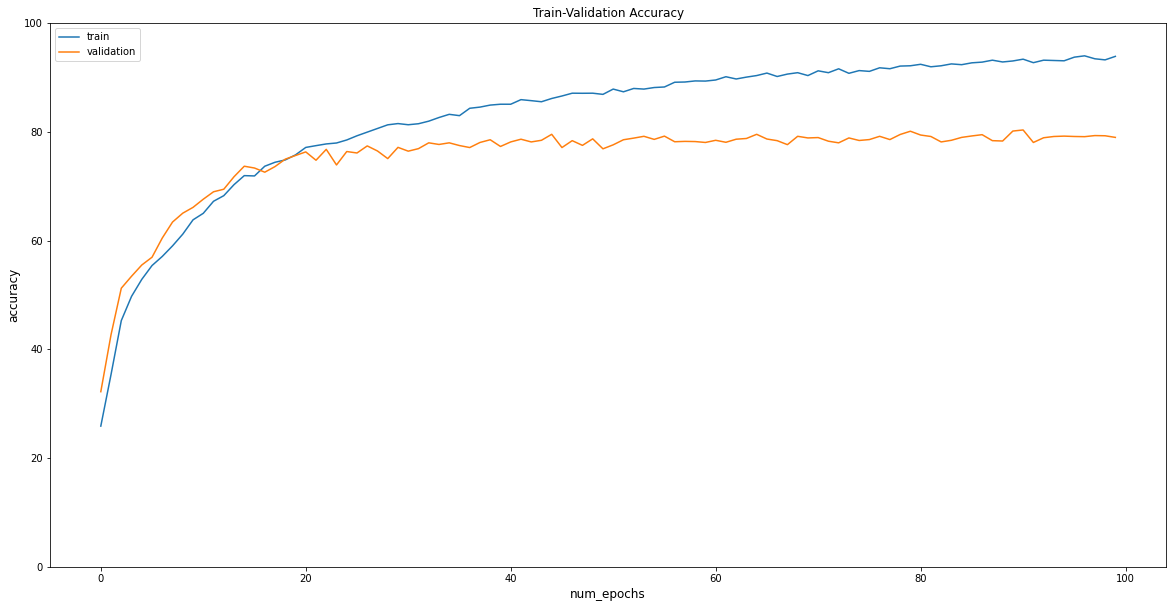

In [83]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))

plt.title("Train-Validation Accuracy")

plt.plot(train_acc, label='train')

plt.plot(val_acc, label='validation')

plt.xlabel('num_epochs', fontsize=12)

plt.ylabel('accuracy', fontsize=12)

plt.ylim((0,100))

plt.legend(loc='best')